<a href="https://colab.research.google.com/github/Shaluram71/Recognizing-UVA-landmarks-with-neural-nets/blob/main/Classifying_UVA_landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 1: Process the  Dataset


In [ ]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2024-11-16 00:45:36--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 74.125.128.95, 74.125.143.95, 173.194.69.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|74.125.128.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M  40.5MB/s    in 10s     

2024-11-16 00:45:47 (36.6 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [ ]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [ ]:
from sklearn.datasets import load_files
#from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150;
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

The pre-trained ResNet50 model has a total of 5 layers in the custom sequential model built on top of the base ResNet50 architecture. The choice of the number of nodes in each layer was guided by balancing model complexity and performance, with 256 and 128 nodes used in the dense layers to gradually reduce the dimensionality and learn intricate features effectively.

For activation functions, ReLU (Rectified Linear Unit) was chosen for the dense layers to introduce non-linearity, which helps the model learn complex patterns, and softmax was used in the output layer to compute probabilities for the 18 classes.

The model has a total of 24,147,474 parameters, out of which 24,094,354 are trainable, and 53,120 are non-trainable, which belong to the pre-trained ResNet50 base. This setup leverages transfer learning by freezing the initial layers while fine-tuning the added layers for the specific dataset.


In [ ]:
# Your code here
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
#Citation for finding out about batch normalization and incorporataing it for faster training less eopchs
#https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/
myModel = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    BatchNormalization(),
    layers.Dense(18, activation='softmax')
])


myModel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

myModel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,470,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,601,106 (36.63 MB)

 Trainable params: 9,599,890 (36.62 MB)

 Non-trainable params: 1,216 (4.75 KB)

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

The model has 10 layers, including three convolutional layers, three max-pooling layers, three batch normalization layers, one flatten layer, two dense layers, a dropout layer, and an output layer. The convolutional layers start with 32 filters and increase to 128, allowing the model to learn simple features like edges in the early layers and more complex patterns like shapes in the deeper ones. Max-pooling layers reduce the size of the data after each convolution, making the model more efficient. The dense layers have 256 and 128 nodes, helping the model combine the features it has learned to make accurate predictions. Batch normalization is used to stabilize the training process and speed it up by normalizing the outputs of the previous layers, which helps the model perform better with fewer training epochs. The dropout layer reduces the risk of overfitting by randomly turning off some connections during training. The final layer has 18 nodes, one for each class, and uses a softmax activation to output probabilities for each class. Overall, the model has about 9.6 million parameters, making it powerful enough to learn complex patterns while still training relatively quickly.

In [ ]:
myEpochs = 15
myOptimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
myLoss = 'sparse_categorical_crossentropy'
myMetrics = ['accuracy']
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit( train_ds,
                      validation_data=validation_ds,
                      epochs = myEpochs)

Epoch 1/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.2577 - loss: 2.6194 - val_accuracy: 0.4060 - val_loss: 2.0024
Epoch 2/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.5231 - loss: 1.5855 - val_accuracy: 0.5219 - val_loss: 1.6011
Epoch 3/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6156 - loss: 1.2876 - val_accuracy: 0.6503 - val_loss: 1.2156
Epoch 4/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7173 - loss: 0.9674 - val_accuracy: 0.6381 - val_loss: 1.2693
Epoch 5/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8124 - loss: 0.6401 - val_accuracy: 0.6076 - val_loss: 1.3275
Epoch 6/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8584 - loss: 0.4622 - val_accuracy: 0.7196 - val_loss: 1.0134
Epoch 7/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9101 - loss: 0.2864 - val_accuracy: 0.7039 - val_loss: 1.1018
Epoch 8/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9405 - loss: 0.1971 - 

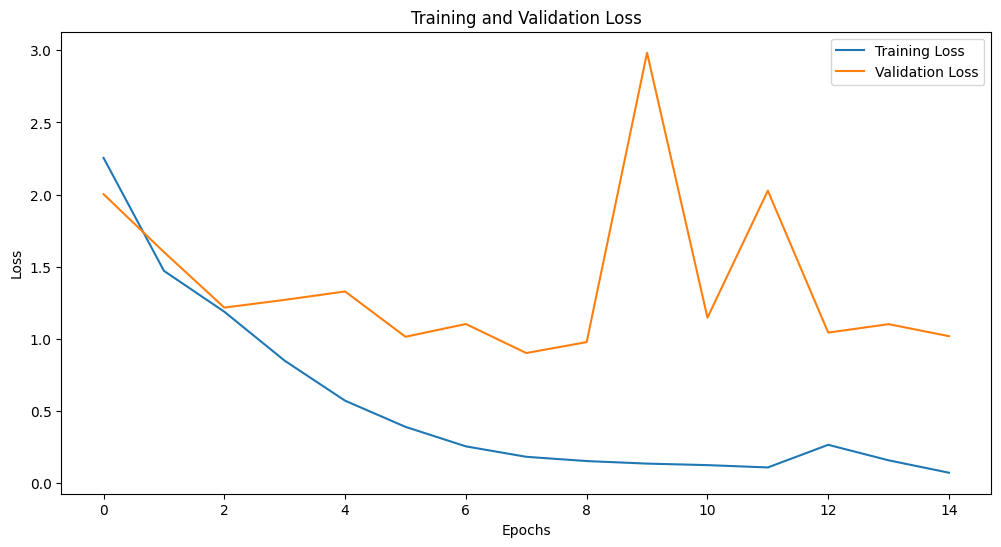

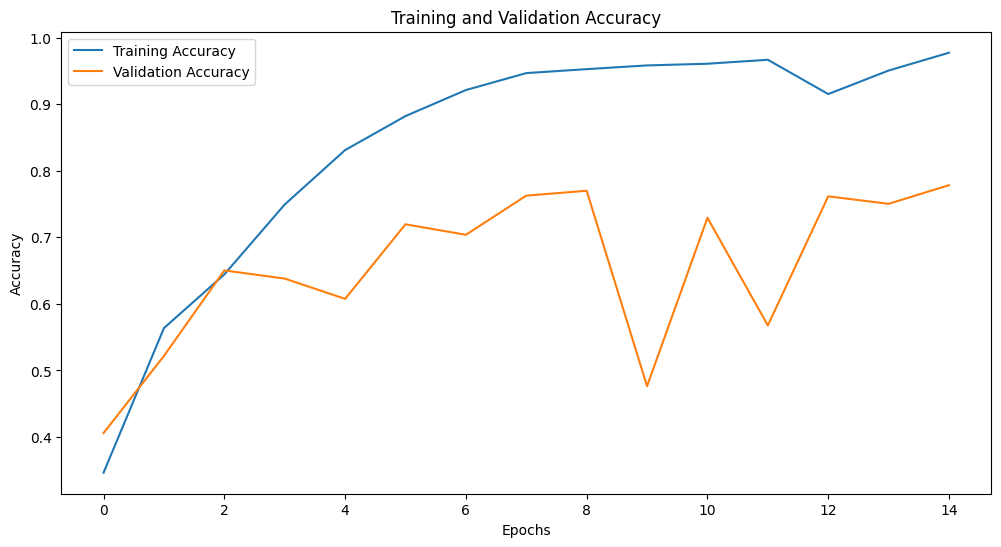

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

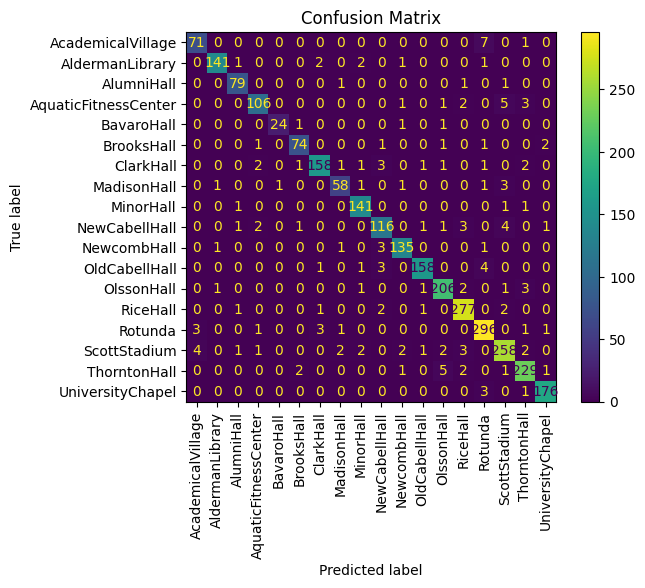

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

validation_preds = np.argmax(myModel.predict(validation_ds), axis=1)
validation_labels = np.concatenate([y.numpy() for x, y in validation_ds])

validation_preds = []
validation_labels = []


for images, labels in validation_ds:
    preds = myModel.predict(images)
    predicted_labels = np.argmax(preds, axis=-1)

    validation_preds.extend(predicted_labels)
    validation_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(validation_labels, validation_preds)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix')
plt.show()



# Step 3: Use a Pre-trained Network with Transfer Learning




In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to 224x224
    batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to 224x224
    batch_size=batch_size
)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

myModel = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(18, activation='softmax')
])

myModel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

myModel.summary()



Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,147,474 (92.12 MB)

 Trainable params: 24,094,354 (91.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [ ]:
# Phase 1 code here
base_model.trainable = False


myModel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase1 = myModel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 71s 163ms/step - accuracy: 0.3823 - loss: 2.0990 - val_accuracy: 0.7312 - val_loss: 0.9613
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.6547 - loss: 1.1585 - val_accuracy: 0.7791 - val_loss: 0.7933
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.7133 - loss: 0.9441 - val_accuracy: 0.8033 - val_loss: 0.6877
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.7445 - loss: 0.8503 - val_accuracy: 0.8278 - val_loss: 0.6254
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.7767 - loss: 0.7477 - val_accuracy: 0.8260 - val_loss: 0.6294
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.7969 - loss: 0.6805 - val_accuracy: 0.8551 - val_loss: 0.5339
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.8214 - loss: 0.5918 - val_accuracy: 0.8547 - val_loss: 0.5431
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 0.8280 - loss: 0

In [ ]:
# Phase 2 code here
base_model.trainable = True

myModel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = myModel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=12,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), # The epoch stopped at 7 due to my early stop to it if it stops improving after a certain point
        tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.95)  # Optional LR decay
    ]
)


Epoch 1/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 189s 388ms/step - accuracy: 0.9718 - loss: 0.0923 - val_accuracy: 0.9349 - val_loss: 0.3455 - learning_rate: 9.5000e-06
Epoch 2/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 156s 317ms/step - accuracy: 0.9768 - loss: 0.0749 - val_accuracy: 0.9412 - val_loss: 0.3289 - learning_rate: 9.0250e-06
Epoch 3/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 144s 324ms/step - accuracy: 0.9794 - loss: 0.0681 - val_accuracy: 0.9429 - val_loss: 0.3295 - learning_rate: 8.5737e-06
Epoch 4/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 324ms/step - accuracy: 0.9816 - loss: 0.0530 - val_accuracy: 0.9461 - val_loss: 0.3243 - learning_rate: 8.1451e-06
Epoch 5/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 139s 316ms/step - accuracy: 0.9865 - loss: 0.0489 - val_accuracy: 0.9429 - val_loss: 0.3389 - learning_rate: 7.7378e-06
Epoch 6/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 145s 323ms/step - accuracy: 0.9884 - loss: 0.0380 - val_accuracy: 0.9443 - val_loss: 0.3402 - learning_rate: 7.3509e-06
Epoch 7/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

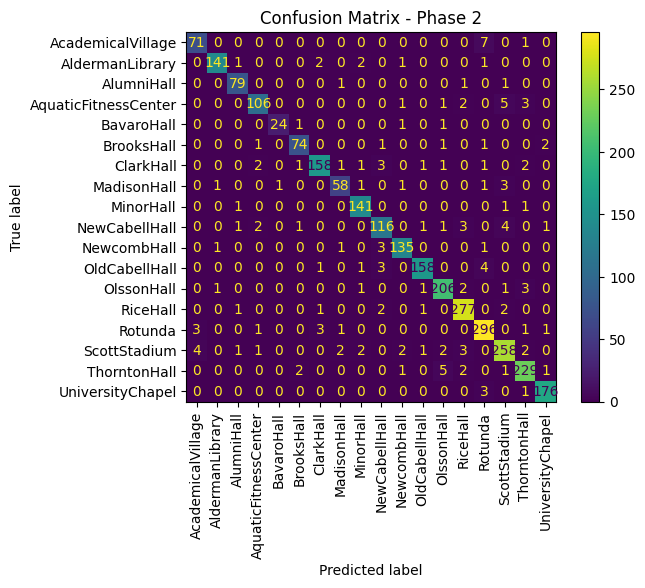

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

validation_preds_phase2 = []
validation_labels_phase2 = []

for images, labels in validation_ds:
    preds = myModel.predict(images)
    predicted_labels = np.argmax(preds, axis=-1)
    validation_preds_phase2.extend(predicted_labels)
    validation_labels_phase2.extend(labels.numpy())
conf_matrix_phase2 = confusion_matrix(validation_labels_phase2, validation_preds_phase2)

disp_phase2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_phase2, display_labels=class_names)
disp_phase2.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix - Phase 2')
plt.show()


The pre-trained transfer learning network performed slightly better overall compared to the custom CNN, although the improvement was not significant across all classes. Notable improvements in accuracy were observed in classes like Rice Hall, which showed a slight increase in performance, and Rotunda, which maintained high accuracy with some refinement. However, Bavaro Hall remains a challenging class for both models, exhibiting relatively low performance and consistent misclassification issues.